# Importing Libraries

In [19]:
import ase.io # for reading *.xyz
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting error distribution
import numpy as np

# Setting Variables and Functions

In [20]:
DATASET_LOCATION = "../data_structures_errors.xyz" # should be in the same directory as the repository

In [21]:
def sort_plot_df(df, sort_method): # to sort df by certain column and display the scatter plot
    df_sorted = df.sort_values(by=[sort_method])

    plt.figure(figsize=(20,10))
    plt.xlabel(sort_method.capitalize())
    plt.ylabel("Energy (Error)")

    plt.ylim(-1.1*df["energy (error)"].abs().max(), 1.1*df["energy (error)"].abs().max())

    # plt.plot(df_sorted[sort_method], df_sorted['energy (error)']) # having lines crowds the entire graph
    plt.scatter(df_sorted[sort_method], df_sorted['energy (error)'], s=10)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.show()

# Reading and Importing Dataset

In [22]:
dataset_list = list(ase.io.iread(filename=DATASET_LOCATION, format="extxyz")) # reading *.xyz file as a generator, then converting into list
df = pd.DataFrame(dataset_list)

df["number of atoms"] = [dataset_list[i].get_global_number_of_atoms() for i in range(len(dataset_list))]
df["chemical formula"] = [dataset_list[i].get_chemical_formula() for i in range(len(dataset_list))]
df["Lattice (unit cell with three vectors)"] = [dataset_list[i].get_cell()[:] for i in range(len(dataset_list))]
df["volume of unit cell (derived from Lattice)"] = [dataset_list[i].get_cell().volume for i in range(len(dataset_list))]
df["energy (error)"] = [dataset_list[i].info["energy"] for i in range(len(dataset_list))]
# Properties part not impt; pbc is "T T T" for all

display(df.head())
print(df.shape)

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,number of atoms,chemical formula,Lattice (unit cell with three vectors),volume of unit cell (derived from Lattice),energy (error)
0,"Atom('Al', [7.02555561, 0.0, 12.73458958], ind...","Atom('Al', [6.96548843, 10.95924854, 17.195571...","Atom('Al', [1.07926452, 5.47962427, 14.9782791...","Atom('Al', [-1.92391455, 13.69906044, 18.33061...","Atom('Al', [4.02237654, 8.21943665, 16.0869255...","Atom('Al', [9.96866703, 2.73981214, 13.8432350...","Atom('Al', [3.7433207, 12.48701859, 14.1275119...","Atom('Al', [9.68961143, 7.00739479, 11.8838224...","Atom('Al', [0.84525955, 1.52777028, 17.5194454...","Atom('Al', [-2.17380166, 12.64488316, 13.75287...",...,None,None,None,None,None,86,HAl60NRh24,"[[11.832514762878418, 0.0, -0.0263979993760585...",6104.848367,0.325074
1,"Atom('Zr', [5.31270552, 11.38425636, 12.790607...","Atom('Zr', [5.31270552, 4.67047501, 12.7906074...","Atom('Zr', [2.12508202, 4.67047501, 10.9502325...","Atom('Zr', [8.50032902, 11.38425636, 10.950232...","Atom('Zr', [7.43778753, 8.75708675, 12.7906074...","Atom('Zr', [1.06254113, 2.04330564, 12.7906074...","Atom('Zr', [4.25016451, 2.04330564, 10.9502315...","Atom('Zr', [4.25016451, 8.75708675, 10.9502315...","Atom('Zr', [5.31270552, 11.38425636, 16.471357...","Atom('Zr', [5.31270552, 4.67047501, 16.4713573...",...,None,None,None,None,None,85,C2HN32O2Se16Zr32,"[[12.750493049621582, 0.0, 0.0], [3.1876232624...",5041.392243,-1.486445
2,"Atom('Ag', [1.99755764, 0.0, 12.556077], index=0)","Atom('Ag', [1.99755764, 0.0, 16.55119133], ind...","Atom('Ag', [1.99755764, 0.0, 20.54630661], ind...","Atom('Ag', [5.99267292, 0.0, 12.556077], index=3)","Atom('Ag', [5.99267292, 0.0, 16.55119133], ind...","Atom('Ag', [5.99267292, 0.0, 20.54630661], ind...","Atom('Ag', [9.9877882, 0.0, 12.556077], index=6)","Atom('Ag', [9.9877882, 0.0, 16.55119133], inde...","Atom('Ag', [9.9877882, 0.0, 20.54630661], inde...","Atom('P', [0.0, 3.52585888, 10.55851936], inde...",...,None,None,None,None,None,66,H2Ag9OP9Pd45,"[[11.985345840454102, 0.0, 0.0], [0.0, 7.05171...",3038.906189,0.198341
3,"Atom('Hf', [9.38242626, 12.50322628, 14.585413...","Atom('Hf', [6.35710812, 3.12580657, 18.5775795...","Atom('Hf', [7.86976767, 7.81451654, 21.8971786...","Atom('Hf', [6.96020222, 13.28467846, 19.901096...","Atom('Hf', [3.93488359, 3.90725827, 23.8932628...","Atom('Hf', [5.44754267, 8.59596825, 16.5814971...","Atom('Hf', [6.20387268, 10.94032288, 18.241296...","Atom('Hf', [3.17855406, 1.56290329, 22.2334613...","Atom('Hf', [4.69121313, 6.25161314, 14.9216957...","Atom('Hf', [5.60077858, 0.7814517, 16.91777992...",...,None,None,None,None,None,62,C2H5Hf30OSn24,"[[8.023002624511719, 0.0, -3.6558828353881836]...",4799.108881,-5.876447
4,"Atom('Tc', [5.52350187, 3.18899536, 15.7963838...","Atom('Tc', [8.28525257, 7.9724884, 20.15400696...","Atom('Tc', [2.76175094, 1.59449768, 17.9751968...","Atom('Tc', [5.52350187, 6.37799072, 17.9751968...","Atom('Tc', [5.52350187, 3.18899536, 20.1540069...","Atom('Tc', [8.28525257, 7.9724884, 24.51163101...","Atom('Tc', [2.76175094, 1.59449768, 22.3328189...","Atom('Tc', [5.52350187, 6.37799072, 22.3328189...","Atom('Tc', [11.04700375, 3.18899536, 15.796383...","Atom('Tc', [13.80875492, 7.9724884, 20.1540069...",...,None,None,None,None,None,67,CH2Os48Tc16,"[[11.047003746032715, 0.0, 0.0], [5.5235018730...",3684.336555,-2.103216


(460333, 230)


In [51]:
mylist = []
for i in range(460332):
    mylist += dataset_list[i].get_chemical_symbols()
    mylist = [*set(mylist)]

mylist = [*set(mylist)]
print(mylist)
print(len(mylist))

['Pt', 'V', 'Os', 'Tc', 'Re', 'Nb', 'Cu', 'Rh', 'Tl', 'Ca', 'O', 'As', 'Ir', 'Zr', 'Al', 'Ga', 'Cd', 'Zn', 'Cs', 'Sr', 'Ru', 'Sb', 'Pb', 'C', 'Hf', 'Na', 'W', 'N', 'P', 'Bi', 'Cr', 'Cl', 'Sn', 'Ni', 'Te', 'Mo', 'Fe', 'Co', 'Ti', 'Se', 'Sc', 'B', 'H', 'Ge', 'K', 'S', 'Au', 'Mn', 'Si', 'Ta', 'Ag', 'Y', 'Hg', 'Pd', 'Rb', 'In']
56


# Exploratory Analysis

,number of atoms,volume of unit cell (derived from Lattice),energy (error)
count,460333.000000,460333.000000,460333.000000
mean,77.747685,4842.312557,-0.021308
std,31.394956,2294.132526,0.828737
min,7.000000,1234.376228,-14.786171
25%,55.000000,3338.281403,-0.254480
50%,73.000000,4279.999428,0.008304
75%,97.000000,5681.454924,0.269678
max,225.000000,29498.801073,12.156693


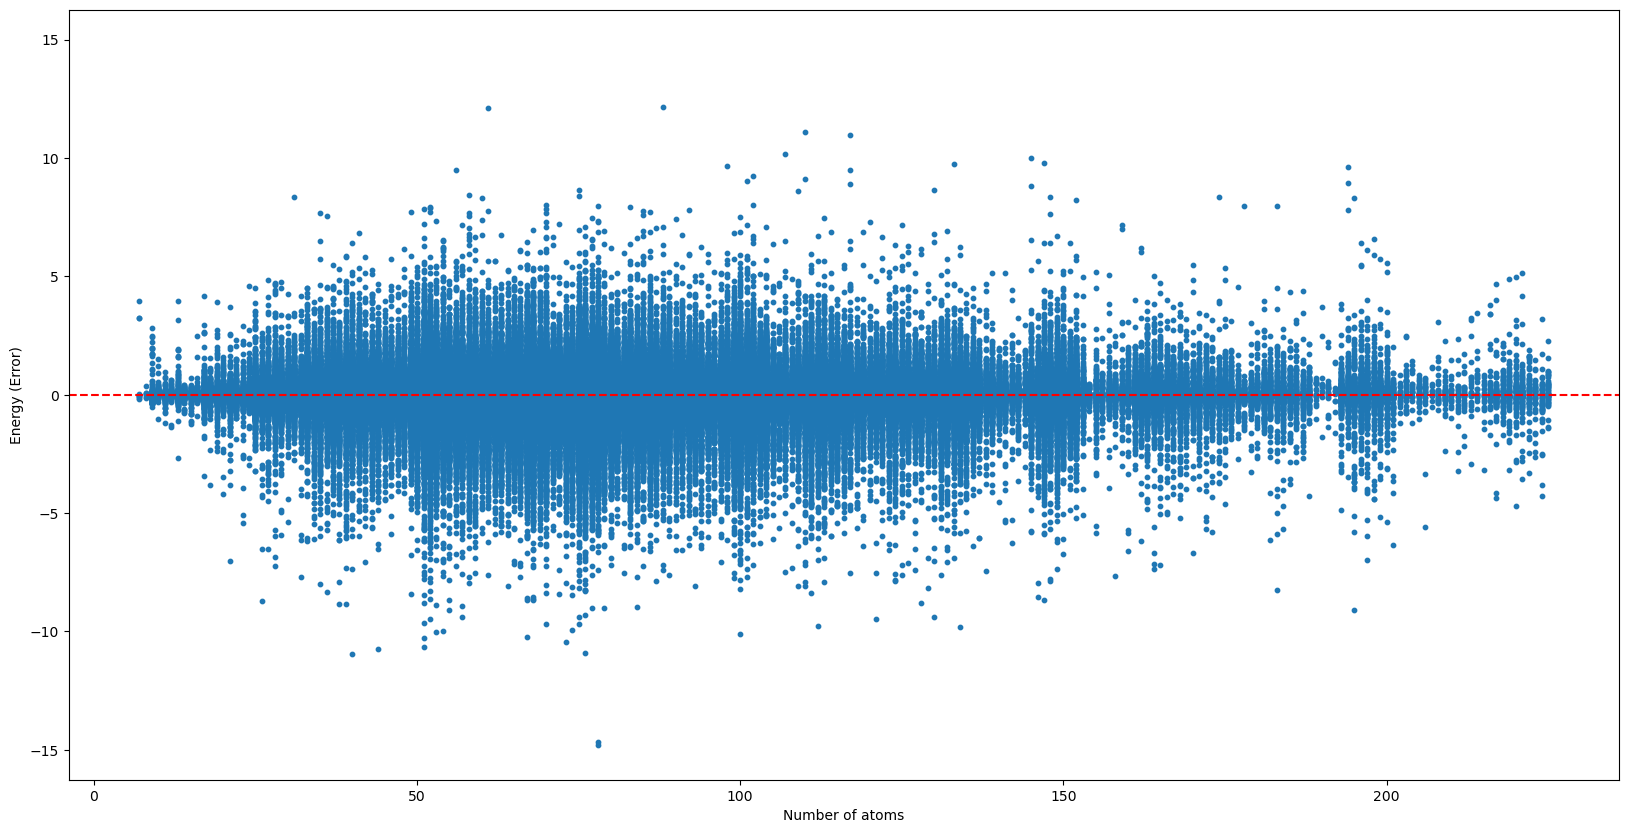

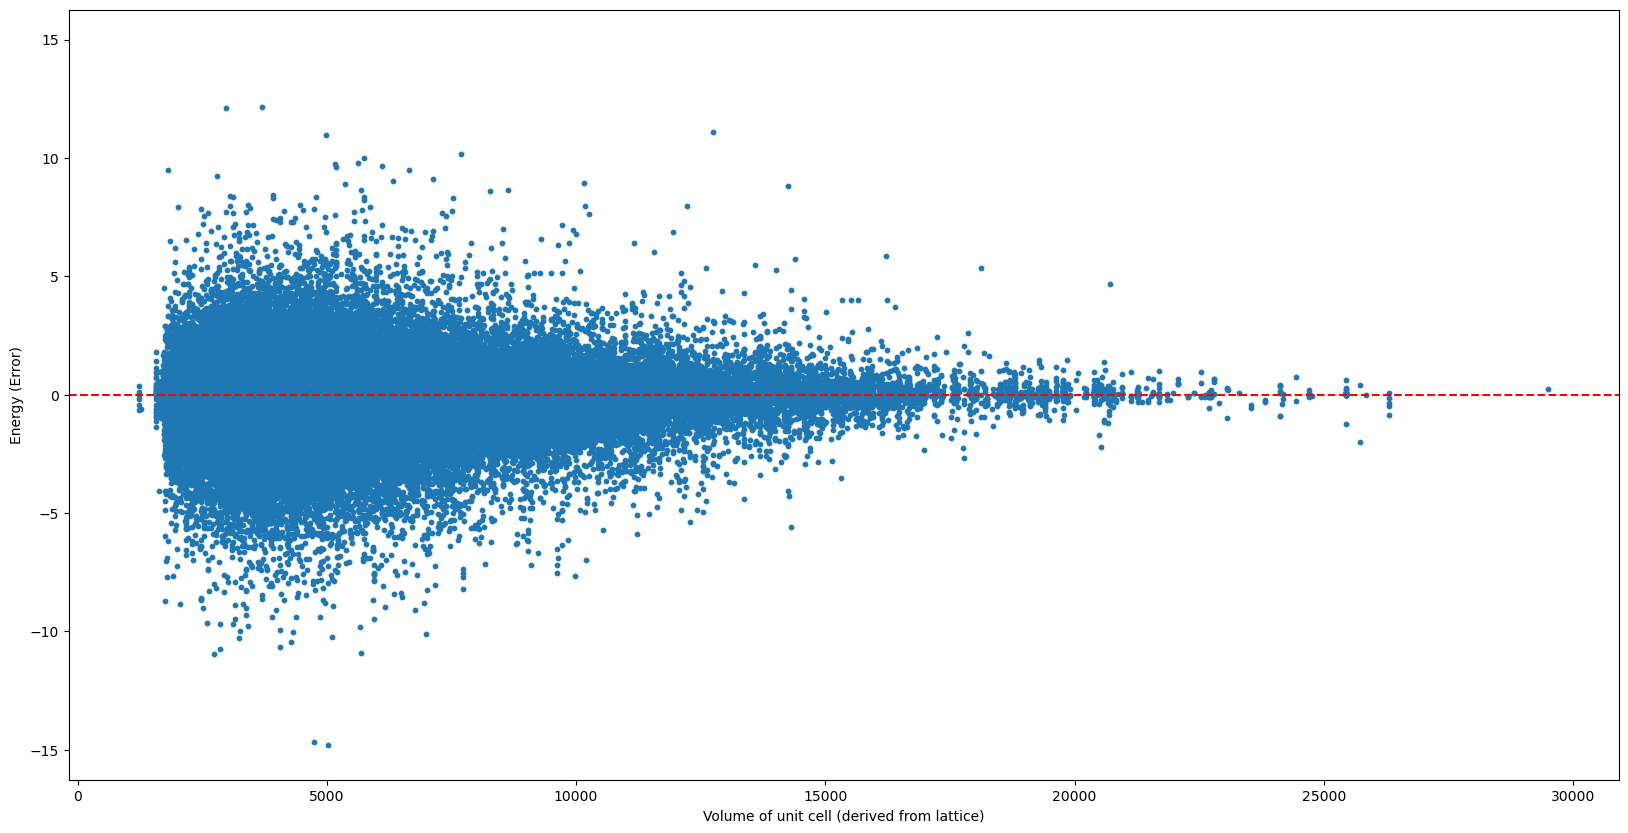

In [23]:
# possible way of extracting data out from Atom object
# print(df[0][0])
# print(df[0][0].symbol)
# print(df[0][0].position)
display(df.describe())
sort_plot_df(df, "number of atoms")
sort_plot_df(df, "volume of unit cell (derived from Lattice)")


In [24]:
# filter for Al
display(df[df['chemical formula'].str.contains('Al')])


,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,number of atoms,chemical formula,Lattice (unit cell with three vectors),volume of unit cell (derived from Lattice),energy (error)
0,"Atom('Al', [7.02555561, 0.0, 12.73458958], ind...","Atom('Al', [6.96548843, 10.95924854, 17.195571...","Atom('Al', [1.07926452, 5.47962427, 14.9782791...","Atom('Al', [-1.92391455, 13.69906044, 18.33061...","Atom('Al', [4.02237654, 8.21943665, 16.0869255...","Atom('Al', [9.96866703, 2.73981214, 13.8432350...","Atom('Al', [3.7433207, 12.48701859, 14.1275119...","Atom('Al', [9.68961143, 7.00739479, 11.8838224...","Atom('Al', [0.84525955, 1.52777028, 17.5194454...","Atom('Al', [-2.17380166, 12.64488316, 13.75287...",...,None,None,None,None,None,86,HAl60NRh24,"[[11.832514762878418, 0.0, -0.0263979993760585...",6104.848367,0.325074
5,"Atom('Al', [7.02555561, 0.0, 12.73458958], ind...","Atom('Al', [6.96548843, 10.95924854, 17.195571...","Atom('Al', [1.07926452, 5.47962427, 14.9782791...","Atom('Al', [-1.92391455, 13.69906044, 18.33061...","Atom('Al', [4.02237654, 8.21943665, 16.0869255...","Atom('Al', [9.96866703, 2.73981214, 13.8432350...","Atom('Al', [3.7433207, 12.48701859, 14.1275119...","Atom('Al', [9.68961143, 7.00739479, 11.8838224...","Atom('Al', [0.84525955, 1.52777028, 17.5194454...","Atom('Al', [-2.17380166, 12.64488316, 13.75287...",...,None,None,None,None,None,86,HAl60NRh24,"[[11.832514762878418, 0.0, -0.0263979993760585...",6104.848367,0.325074
12,"Atom('Sc', [2.238976, 4.74958563, 13.45715904]...","Atom('Sc', [2.238976, 1.58319509, 16.62354851]...","Atom('Sc', [2.238976, 1.58319509, 13.45715904]...","Atom('Sc', [2.238976, 4.74958563, 16.62354851]...","Atom('Sc', [0.0, 3.16639018, 18.20674515], ind...","Atom('Sc', [0.0, 0.0, 15.04035378], index=5)","Atom('Sc', [2.238976, 4.74958563, 19.78993988]...","Atom('Sc', [2.238976, 1.58319509, 22.95632935]...","Atom('Sc', [2.238976, 1.58319509, 19.78993988]...","Atom('Sc', [2.238976, 4.74958563, 22.95632935]...",...,None,None,None,None,None,69,CH3Al16OSc48,"[[8.955904006958008, 0.0, 0.0], [0.0, 12.66556...",4310.022727,0.101882
40,"Atom('Al', [0.0, 0.0, 18.09925842], index=0)","Atom('Al', [2.16263175, 1.24859595, 14.5676965...","Atom('Al', [4e-08, 2.49719191, 11.03613377], i...","Atom('Al', [2.16263175, 1.24859595, 19.8650398...","Atom('Al', [4e-08, 2.49719191, 16.33347702], i...","Atom('Al', [0.0, 0.0, 12.80191517], index=5)","Atom('Al', [-2.16263175, 3.74578786, 18.099258...","Atom('Al', [-5e-08, 4.99438381, 14.56769657], ...","Atom('Al', [-2.16263175, 6.24298, 11.03613377]...","Atom('Al', [-5e-08, 4.99438381, 19.86503983], ...",...,None,None,None,None,None,51,H2Al24Cu12OPd12,"[[8.650527000427246, 0.0, 0.0], [-4.3252635002...",2059.800612,0.041170
64,"Atom('Y', [0.54843384, 1.34731531, 23.26649094...","Atom('Y', [2.74216914, 6.73657656, 17.41383362...","Atom('Y', [1.64530158, 4.04194593, 14.52141953...","Atom('Y', [3.83903694, 9.43120766, 20.3062458]...","Atom('Y', [6.05849504, 2.2455256, 14.52141953]...","Atom('Y', [8.25223064, 7.63478661, 20.3062458]...","Atom('Y', [6.04563379, 8.53299713, 14.48750401...","Atom('Y', [3.85189843, 3.14373589, 20.34016228...","Atom('Al', [5.29709053, 0.37501401, 12.5136146...","Atom('Al', [7.49082613, 5.76427507, 18.2984409...",...,None,None,None,None,None,80,C2H2Al8Co60Y8,"[[7.716658115386963, 0.0, -2.926328659057617],...",2903.814382,0.125933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460231,"Atom('Al', [4e-08, 2.4995997, 12.81425858], in...","Atom('Al', [0.0, 0.0, 19.88419342], index=1)","Atom('Al', [2.16471672, 1.24979985, 16.349226]...","Atom('Al', [-2.16471672, 6.24899912, 12.814258...","Atom('Al', [-2.16471672, 3.74939942, 19.884193...","Atom('Al', [-5e-08, 4.99919939, 16.349226], in...","Atom('Al', [4.32943392, 2.4995997, 12.81425858...","Atom('Al', [4.32943344, 0.0, 19.88419342], ind...","Atom('Al', [6.49415064, 1.24979985, 16.349226]...","Atom('Al', [2.16471696, 6.24899912, 12.8142585...",...,None,None,None,None,Non